In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D,\
    Dense, Layer, Reshape, InputLayer, Flatten, Input, MaxPooling2D
from alibi_detect.od import OutlierAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
def img_to_np(path, resize = True):  
    img_array = []
    fpaths = glob.glob(path)
    for fname in fpaths:
        img = Image.open(fname).convert("RGB")
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
    images = np.array(img_array)
    return images

path = "D:\\cybord\\img\\comp4\\*.*"
train = img_to_np(path)
train = train.astype('float32') / 255.
#test = test.astype('float32') / 255.

print(train.shape)

(1007, 64, 64, 3)


In [3]:
encoding_dim = 1024

encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(8*8*128),
      Reshape(target_shape=(8, 8, 128)),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])


# initialize outlier detector
od = OutlierAE( threshold = 0.001,
                encoder_net=encoder_net,
                decoder_net=decoder_net,)

adam = tf.keras.optimizers.Adam(lr=1e-4)

# train
od.fit(train, epochs=100, verbose=True,
       optimizer = adam)

#decoder_net.summary()

16/16 [=] - 1s 43ms/step - loss: 4.8857e-04


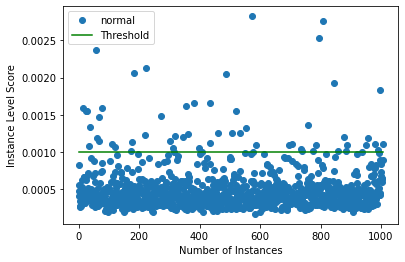

Counter({0: 948, 1: 59})

In [4]:
preds = od.predict(train, outlier_type='instance',
            return_instance_score=True,
            return_feature_score=True)

target = np.zeros(train.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(preds, target, labels, od.threshold)

Counter(preds['data']['is_outlier'])

<Figure size 864x576 with 0 Axes>

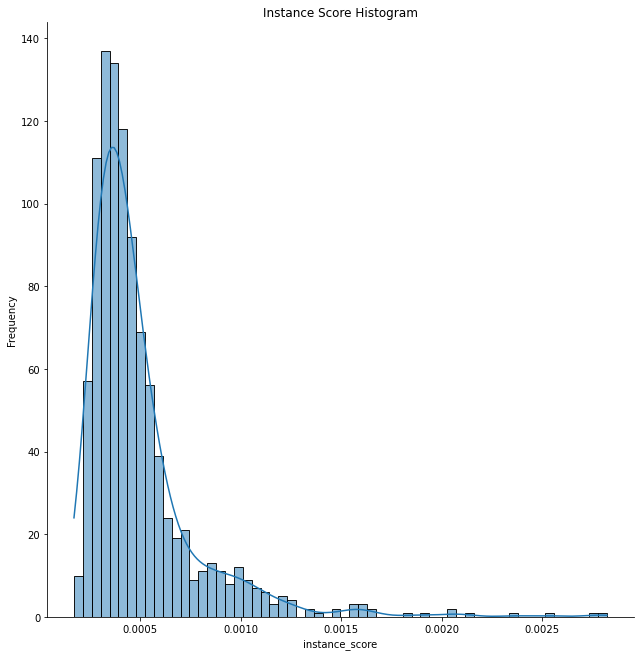

threshold: 0.001


In [5]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.displot(data=preds['data'], x='instance_score', kde=True, height=9)
plt.title('Instance Score Histogram')
plt.ylabel('Frequency')
plt.show()

thresh = od.threshold
print("threshold:", thresh)

In [6]:
print('99th percentile:', np.percentile(preds['data']['instance_score'], 90))

99th percentile: 0.0008318798616528511


In [7]:
fpaths = glob.glob('img/*.*')
for fname in fpaths:
    os.remove(fname)

img_full = img_to_np(path, resize=False)

for i, pred in enumerate(preds['data']['is_outlier']):
    if(pred == 1):
        #plt.imshow(img_full[i])
        #plt.savefig("img/" + str(i) + ".jpg")
        img = Image.fromarray(img_full[i])
        img = img.save("img/" + str(i) + ".jpg")

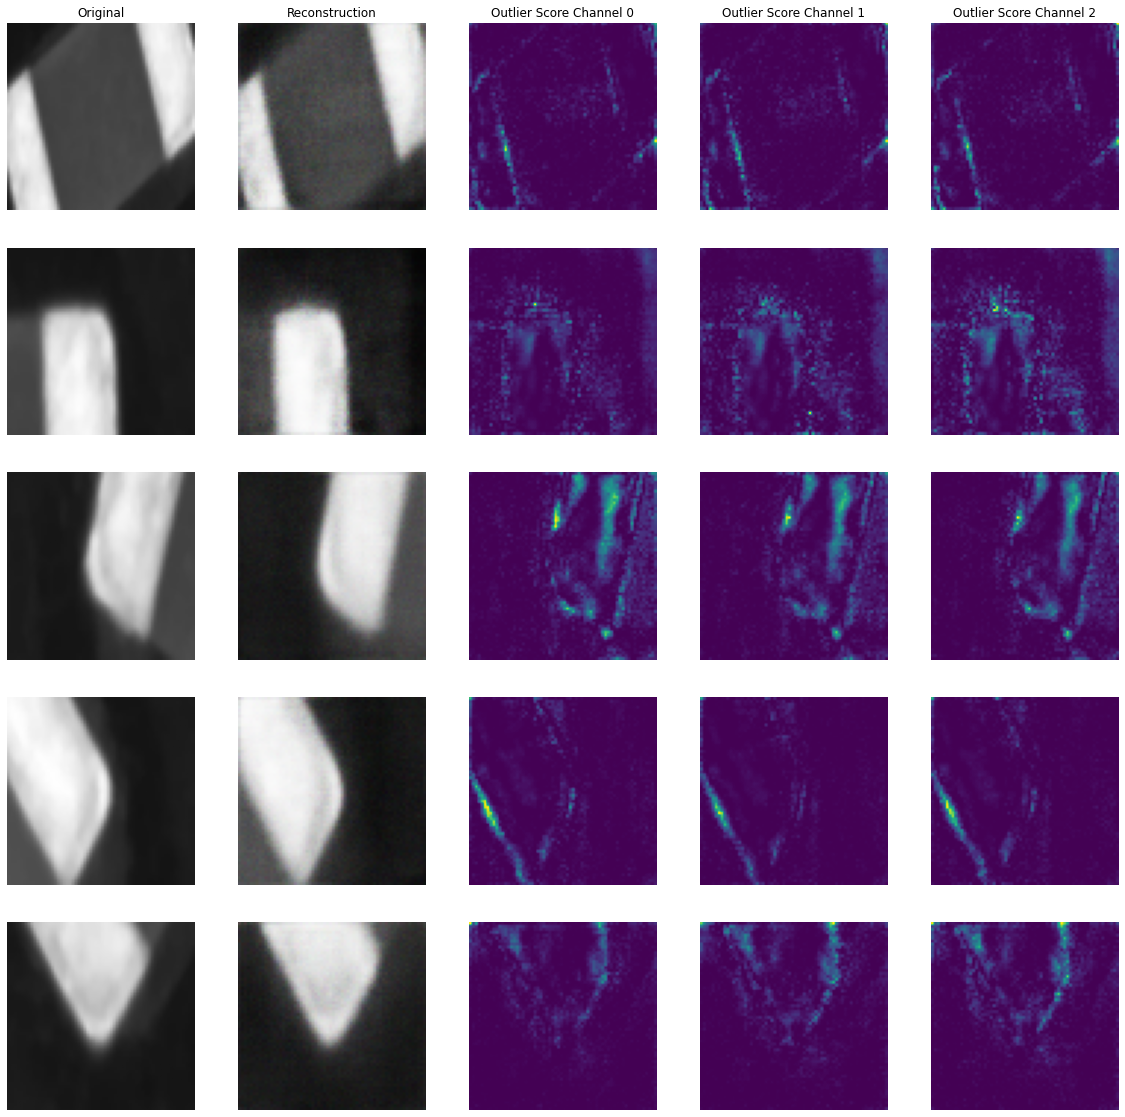

In [8]:
recon = od.ae(train).numpy()

plot_feature_outlier_image(preds, train, 
                           X_recon=recon,  
                           max_instances=5,
                           outliers_only=True,
                           figsize=(20,20))